# What The Hack: Machine Learning Hackathon

Problem Statement: Develop a neural network that learns to apply the Sobel filter to images.

- Name: Shardul Junagade
- Batch: BTech CSE '23
- Roll Number: 23110297

# Importing Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Loading Datasets

**First run the preprocessing.ipynb file to save the required datasets in .npy format and also update all the paths.**

In [3]:
# load the data
X_train_og = np.load("/kaggle/input/saved-natural/X_train.npy")
X_test_og = np.load("/kaggle/input/saved-natural/X_test.npy")
y_train_og = np.load("/kaggle/input/saved-natural/y_train.npy")
y_test_og = np.load("/kaggle/input/saved-natural/y_test.npy")

# Normalize the images
X_train = X_train_og / 255.0
X_test = X_test_og / 255.0
y_train = y_train_og / 255.0
y_test = y_test_og / 255.0

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
del X_train_og, X_test_og, y_train_og, y_test_og

(5519, 256, 256) (1380, 256, 256) (5519, 256, 256) (1380, 256, 256)


In [4]:
# Check for data range and type
print(f"X_train min: {np.min(X_train)}, max: {np.max(X_train)}")
print(f"X_test min: {np.min(X_test)}, max: {np.max(X_test)}")
print(f"y_train min: {np.min(y_train)}, max: {np.max(y_train)}")
print(f"y_test min: {np.min(y_test)}, max: {np.max(y_test)}")

X_train min: 0.0, max: 1.0
X_test min: 0.0, max: 1.0
y_train min: 0.0, max: 1.0
y_test min: 0.0, max: 1.0


In [5]:
print(f"NaN in X_train: {np.any(np.isnan(X_train))}, Inf in X_train: {np.any(np.isinf(X_train))}")
print(f"NaN in y_train: {np.any(np.isnan(y_train))}, Inf in y_train: {np.any(np.isinf(y_train))}")

NaN in X_train: False, Inf in X_train: False
NaN in y_train: False, Inf in y_train: False


# Model

In [6]:
def build_unet_model():
    inputs = layers.Input(shape=(256, 256, 1))
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)          # Output size: (128, 128)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)          # Output size: (64, 64)
    
    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c5)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

model = build_unet_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │    131,200 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 256, 256,  │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,861,697 (7.10 MB)

 Trainable params: 1,861,697 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

# Utilities

In [7]:
def custom_accuracy(y_true, y_pred, threshold=0.1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    diff = tf.abs(y_true - y_pred)
    correct_pixels = tf.less_equal(diff, threshold)
    accuracy = tf.reduce_mean(tf.cast(correct_pixels, tf.float32))
    return accuracy


def lr_scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        new_lr = lr * tf.math.exp(-0.1)
        return float(new_lr.numpy())

    
def train_model(X_train, y_train, X_test, y_test, use_lr_scheduler=False, save_model=False, filter_type="sobel"):
    model = build_unet_model()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='mse',
                  metrics=['mse', 'mae'])

    callbacks = [LearningRateScheduler(lr_scheduler)] if use_lr_scheduler else []

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=callbacks
    )
    
    if save_model:
        # Save the model
        model_name = f"{filter_type}_filter_model_with_lr.h5" if use_lr_scheduler else f"{filter_type}_filter_model_without_lr.h5"
        model.save(model_name)

    return model, history


# Evaluate the model
def evaluate_model(model, X_test, y_test):
    _, mse, mae = model.evaluate(X_test, y_test)
    print(f"Test MSE: {mse}")
    print(f"Test MAE: {mae}")

    # Predict and post-process
    y_pred = model.predict(X_test)
    y_pred = np.squeeze(y_pred, axis=-1)

    # Ensure y_test and y_pred are of type float32 and in range [0, 1]
    y_test = tf.clip_by_value(tf.cast(y_test, tf.float32), 0.0, 1.0)
    y_pred = tf.clip_by_value(tf.cast(y_pred, tf.float32), 0.0, 1.0)

    # Calculate custom accuracy
    custom_acc = custom_accuracy(y_test, y_pred, threshold=0.1).numpy()
    print(f"Custom Accuracy: {custom_acc * 100:.2f}%")

    # Compute SSIM
    ssim = tf.image.ssim(y_test, y_pred, max_val=1.0)
    print(f"SSIM (Structural Similarity Index): {tf.reduce_mean(ssim).numpy()}")

    return y_pred


def plot_sample(image, true_sobel, predicted_sobel):
    image = image.numpy().squeeze() if isinstance(image, tf.Tensor) else image.squeeze()
    true_sobel = true_sobel.numpy().squeeze() if isinstance(true_sobel, tf.Tensor) else true_sobel.squeeze()
    predicted_sobel = predicted_sobel.numpy().squeeze() if isinstance(predicted_sobel, tf.Tensor) else predicted_sobel.squeeze()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Sobel")
    plt.imshow(true_sobel.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Sobel")
    plt.imshow(predicted_sobel.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()
    

# Training with Learning Rate Scheduler

Epoch 1/10


I0000 00:00:1725537772.245820     102 service.cc:145] XLA service 0x7c22bc009390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725537772.245884     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725537809.685059     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


173/173 ━━━━━━━━━━━━━━━━━━━━ 139s 565ms/step - loss: 0.0757 - mae: 0.2204 - mse: 0.0757 - val_loss: 0.0214 - val_mae: 0.0975 - val_mse: 0.0214 - learning_rate: 1.0000e-04
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 432ms/step - loss: 0.0182 - mae: 0.0859 - mse: 0.0182 - val_loss: 0.0150 - val_mae: 0.0733 - val_mse: 0.0150 - learning_rate: 1.0000e-04
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 432ms/step - loss: 0.0140 - mae: 0.0697 - mse: 0.0140 - val_loss: 0.0124 - val_mae: 0.0624 - val_mse: 0.0124 - learning_rate: 1.0000e-04
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 432ms/step - loss: 0.0117 - mae: 0.0601 - mse: 0.0117 - val_loss: 0.0107 - val_mae: 0.0545 - val_mse: 0.0107 - learning_rate: 1.0000e-04
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 432ms/step - loss: 0.0102 - mae: 0.0529 - mse: 0.0102 - val_loss: 0.0094 - val_mae: 0.0490 - val_mse: 0.0094 - learning_rate: 1.0000e-04
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 432ms/step - loss: 0.0090 - mae: 0.0478 - mse: 0.0090 - val_l

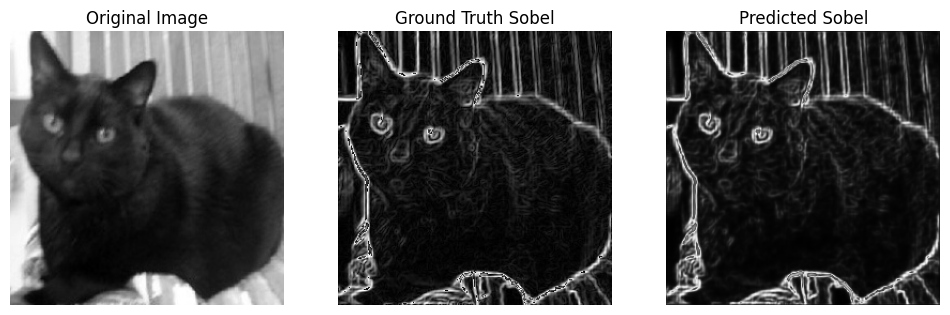

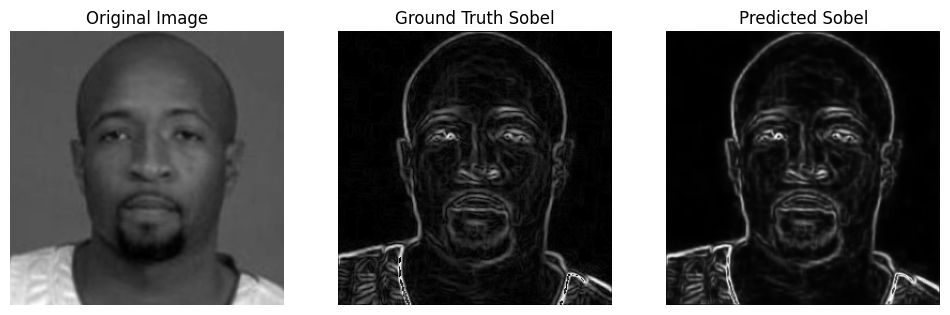

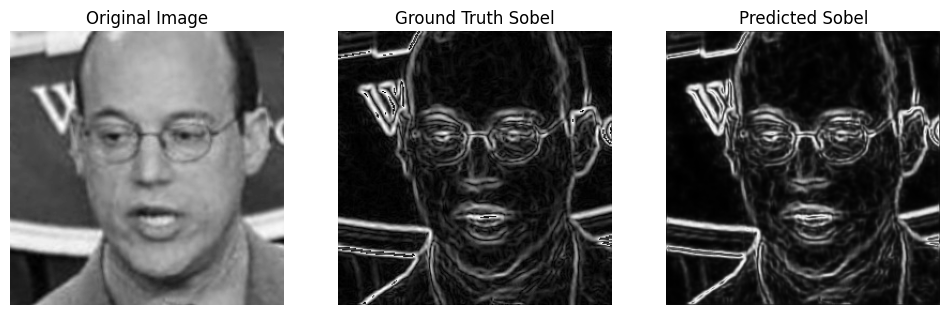

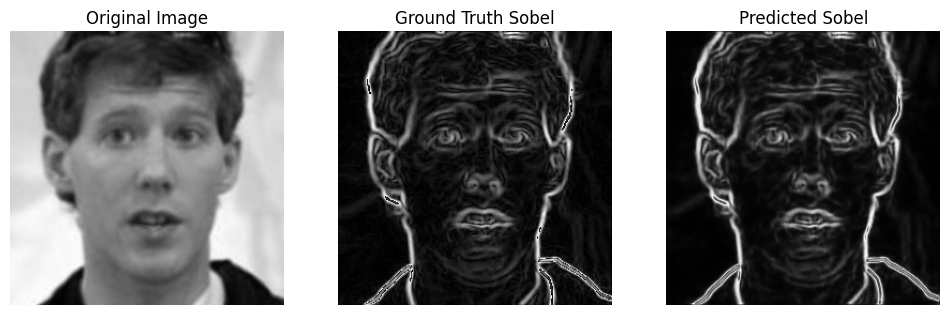

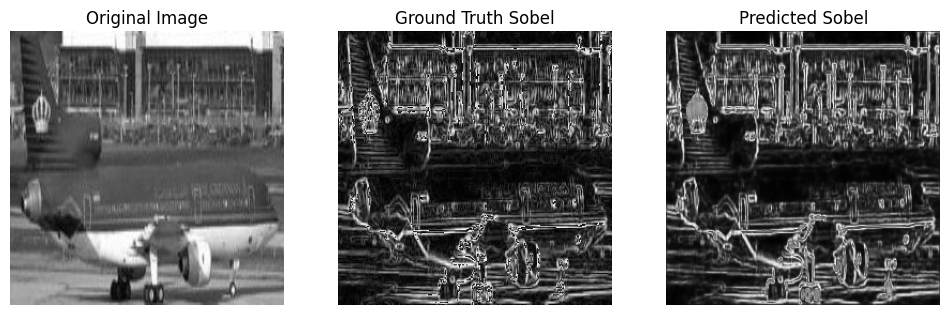

In [8]:
# Train and evaluate model with learning rate scheduler
model_with_lr, history_with_lr = train_model(X_train, y_train, X_test, y_test, use_lr_scheduler=True, save_model=True)
y_pred_with_lr = evaluate_model(model_with_lr, X_test, y_test)

# Plot samples from the model trained with learning rate scheduler
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    plot_sample(X_test[idx], y_test[idx], y_pred_with_lr[idx])

# Training without Learning Rate Scheduler

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 83s 453ms/step - loss: 0.0747 - mae: 0.2166 - mse: 0.0747 - val_loss: 0.0178 - val_mae: 0.0836 - val_mse: 0.0178
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 433ms/step - loss: 0.0164 - mae: 0.0788 - mse: 0.0164 - val_loss: 0.0136 - val_mae: 0.0672 - val_mse: 0.0136
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 82s 433ms/step - loss: 0.0129 - mae: 0.0645 - mse: 0.0129 - val_loss: 0.0114 - val_mae: 0.0576 - val_mse: 0.0114
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 433ms/step - loss: 0.0110 - mae: 0.0558 - mse: 0.0110 - val_loss: 0.0099 - val_mae: 0.0508 - val_mse: 0.0099
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 433ms/step - loss: 0.0094 - mae: 0.0491 - mse: 0.0094 - val_loss: 0.0088 - val_mae: 0.0461 - val_mse: 0.0088
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 433ms/step - loss: 0.0084 - mae: 0.0446 - mse: 0.0084 - val_loss: 0.0081 - val_mae: 0.0426 - val_mse: 0.0081
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 433ms/step - loss: 0.0078 - mae: 0.041

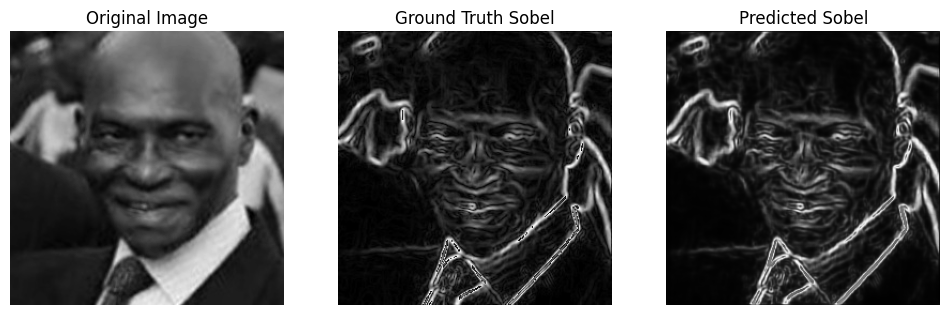

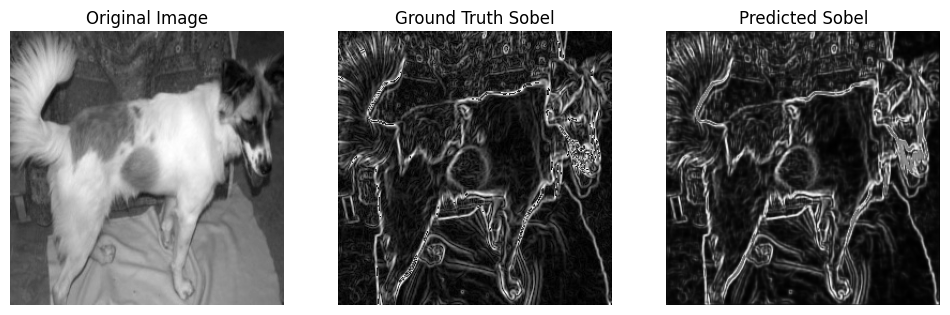

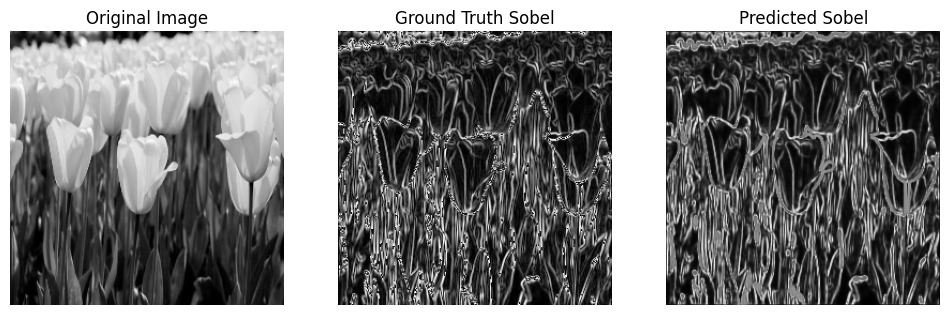

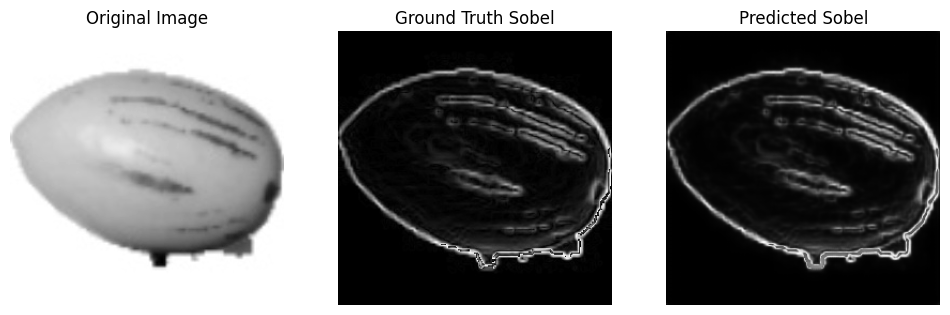

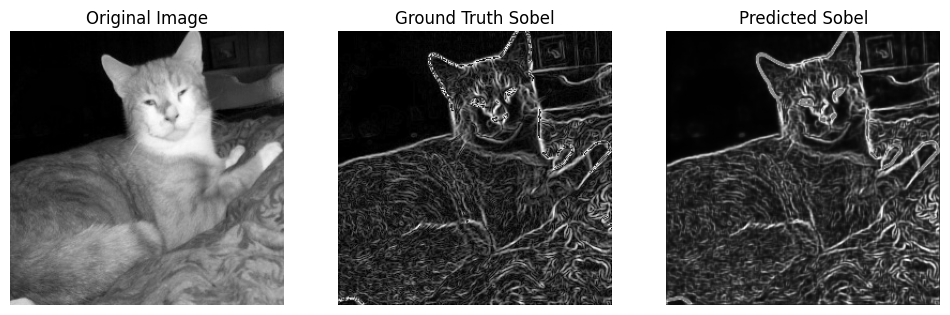

In [10]:
# Train and evaluate model without learning rate scheduler
model_without_lr, history_without_lr = train_model(X_train, y_train, X_test, y_test, use_lr_scheduler=False, save_model=True)
y_pred_without_lr = evaluate_model(model_without_lr, X_test, y_test)

# Plot samples from the model trained without learning rate scheduler
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    plot_sample(X_test[idx], y_test[idx], y_pred_without_lr[idx])

# Results:

After training for 10 epochs, the model achieved the following performance:

| Model                          | MSE (Test) | MAE (Test) | Custom Accuracy (%) | SSIM (Test) |
|--------------------------------|------------|------------|---------------------|-------------|
| With Learning Rate Scheduler   | 0.0065     | 0.0364     | 92.9              | 0.91        |
| Without Learning Rate Scheduler| 0.0064     | 0.0338    | 93.47               | 0.916        |


